In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import os

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Airtel")

In [3]:
df_airtel= pd.read_csv(os.getcwd()+r"\Data Files\airtel_scores_combined.csv")
df_hc= pd.read_csv(os.getcwd()+r"\Data Files\loan performance.csv")

In [4]:
df_hc["TIME_DECISION_DATE"] = pd.to_datetime(df_hc["TIME_DECISION_DATE"], format = '%d-%m-%y')

In [5]:
df_hc["SEGMENT"] = np.where(df_hc["TIME_DECISION_DATE"]>=pd.datetime(2020,6,1),"JUN20","OCT19")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [6]:
df_airtel.head()

,score,MSISDN,SEGMENT
0,0.132862,6200275881,JUN20
1,0.106377,6200359513,JUN20
2,0.152042,6200526732,JUN20
3,0.117159,6201046360,JUN20
4,0.163676,6202137852,JUN20


In [7]:
df_hc.head()

,SKP_CREDIT_CASE,TEXT_CONTACT,TIME_DECISION_DATE,PRODUCT_GROUP,CLIENT_EXI_3M,RISK_SCORE,DECISION_OVERALL,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,FLAG_1PCT_PHANTOM,SEGMENT
0,308848598,9599873362,2020-06-27,CD,N,0.010056,Rejected,0,0,0,0,JUN20
1,307730602,9500427367,2020-06-11,ACL,N,NaN,Rejected,0,0,0,0,JUN20
2,307453027,9065521222,2020-06-08,CD,Y,NaN,Rejected,0,0,0,0,JUN20
3,307901079,7289856147,2020-06-14,ACL,N,NaN,Rejected,0,0,0,0,JUN20
4,311994477,8264378001,2020-07-23,CD,N,0.019203,Rejected,0,0,0,0,JUN20


In [8]:
df = df_hc.merge(df_airtel,how = 'left', left_on = ["TEXT_CONTACT","SEGMENT"], right_on=["MSISDN","SEGMENT"])
df.head()

,SKP_CREDIT_CASE,TEXT_CONTACT,TIME_DECISION_DATE,PRODUCT_GROUP,CLIENT_EXI_3M,RISK_SCORE,DECISION_OVERALL,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,FLAG_1PCT_PHANTOM,SEGMENT,score,MSISDN
0,308848598,9599873362,2020-06-27,CD,N,0.010056,Rejected,0,0,0,0,JUN20,0.114659,9.599873e+09
1,307730602,9500427367,2020-06-11,ACL,N,NaN,Rejected,0,0,0,0,JUN20,NaN,NaN
2,307453027,9065521222,2020-06-08,CD,Y,NaN,Rejected,0,0,0,0,JUN20,NaN,NaN
3,307901079,7289856147,2020-06-14,ACL,N,NaN,Rejected,0,0,0,0,JUN20,NaN,NaN
4,311994477,8264378001,2020-07-23,CD,N,0.019203,Rejected,0,0,0,0,JUN20,NaN,NaN


# Found Rate

In [9]:
df["FOUND_FLAG"] = np.where(df.score.isna(),0,1)

df_found_rate= df[df["PRODUCT_GROUP"].isin(["CD","ACL","CL"])][["PRODUCT_GROUP","CLIENT_EXI_3M","SEGMENT","FOUND_FLAG"]].groupby(
    ["PRODUCT_GROUP","CLIENT_EXI_3M","SEGMENT"]).agg(["count","sum","mean"])

df_found_rate.columns = ["_".join([x,y]) for (x,y) in df_found_rate.columns]
df_found_rate.reset_index(inplace = True)


df_found_rate.columns = ["PRODUCT_GROUP","CLIENT_EXI_3M","SEGMENT","COUNT","FOUND","FOUND_RATE"]
df_found_rate

,PRODUCT_GROUP,CLIENT_EXI_3M,SEGMENT,COUNT,FOUND,FOUND_RATE
0,ACL,N,JUN20,35222,6523,0.185197
1,ACL,N,OCT19,6110,1212,0.198363
2,ACL,Y,JUN20,18205,3382,0.185773
3,ACL,Y,OCT19,1516,303,0.199868
4,CD,N,JUN20,282447,44378,0.157120
5,CD,N,OCT19,61237,9736,0.158989
6,CD,Y,JUN20,149146,25710,0.172381
7,CD,Y,OCT19,44090,7796,0.176820
8,CL,N,OCT19,10,2,0.200000
9,CL,Y,JUN20,9966,1812,0.181818


# CD Analysis

In [10]:
df=df[df.PRODUCT_GROUP=="CD"]

### Correlation

In [11]:
df_corr= df.dropna(subset = ["score","RISK_SCORE"])
print("Correlation Coeffecint(Pearson's): ",'{:.3f}'.format(df_corr["score"].corr(df_corr["RISK_SCORE"])))

Correlation Coeffecint(Pearson's):  0.006


### Decile Wise Reject Rates (Weighted as per actual reject rates in Jun'20-Jul'20)

In [12]:
from sklearn.utils import resample
dic_reject_rate = {'Y':0.52,
                  'N':0.575,
                  'OVERALL':0.557}

#### New Clients

In [13]:
df_reject = df[(df.DECISION_OVERALL.isin(['Approved','Rejected']))&(df.CLIENT_EXI_3M=='N')].dropna(subset = ["score"])
df_reject["SCORE_BIN"] = pd.qcut(df_reject.score,q=10, precision = 3)
df_reject = df_reject[df_reject.SEGMENT=='JUN20']

In [14]:
df_rejected = df_reject[df_reject['DECISION_OVERALL']=='Rejected']
df_approved = df_reject[df_reject['DECISION_OVERALL']=='Approved']
count_reject_final = round((dic_reject_rate["OVERALL"]/(1-dic_reject_rate["OVERALL"]))*len(df_approved))
df_rejected_upsampled = resample(df_rejected,replace=True, n_samples=count_reject_final,random_state=123) 
df_reject_upsampled = pd.concat([df_approved, df_rejected_upsampled])
df_reject_upsampled["APPROVED_FLAG"] = np.where(df_reject_upsampled["DECISION_OVERALL"]=="Approved",1,0)
df_reject_summ=df_reject_upsampled[["SCORE_BIN","APPROVED_FLAG"]].groupby(["SCORE_BIN"]).agg(["count","sum","mean"])
df_reject_summ.columns = ["_".join([x,y]) for (x,y) in df_reject_summ.columns]
df_reject_summ["FPD30_RATE"] = df_reject_upsampled[df_reject_upsampled.DECISION_OVERALL=="Approved"][["SCORE_BIN","RISK_FPD30"]].groupby(["SCORE_BIN"]).mean()
df_reject_summ.columns = ["COUNT","APPROVED","APPROVAL_RATE","FPD30_RATE"]
df_reject_summ

,COUNT,APPROVED,APPROVAL_RATE,FPD30_RATE
SCORE_BIN,,,,
"(0.011099999999999999, 0.0556]",6204,3087,0.497582,0.011986
"(0.0556, 0.0691]",6449,3089,0.478989,0.016834
"(0.0691, 0.081]",6535,3015,0.461362,0.021227
"(0.081, 0.0932]",6624,2937,0.443388,0.022131
"(0.0932, 0.106]",6610,2893,0.437670,0.028344
"(0.106, 0.121]",6529,2844,0.435595,0.027426
"(0.121, 0.139]",6492,2832,0.436229,0.035664
"(0.139, 0.163]",6695,2740,0.409261,0.043431
"(0.163, 0.201]",6533,2762,0.422777,0.045619


#### Exi Clients

In [15]:
df_reject = df[(df.DECISION_OVERALL.isin(['Approved','Rejected']))&(df.CLIENT_EXI_3M=='Y')].dropna(subset = ["score"])
df_reject["SCORE_BIN"] = pd.qcut(df_reject.score,q=10, precision = 3)
df_reject = df_reject[df_reject.SEGMENT=='JUN20']

In [16]:
df_rejected = df_reject[df_reject['DECISION_OVERALL']=='Rejected']
df_approved = df_reject[df_reject['DECISION_OVERALL']=='Approved']
count_reject_final = round((dic_reject_rate["OVERALL"]/(1-dic_reject_rate["OVERALL"]))*len(df_approved))
df_rejected_upsampled = resample(df_rejected,replace=True, n_samples=count_reject_final,random_state=123) 
df_reject_upsampled = pd.concat([df_approved, df_rejected_upsampled])
df_reject_upsampled["APPROVED_FLAG"] = np.where(df_reject_upsampled["DECISION_OVERALL"]=="Approved",1,0)
df_reject_summ=df_reject_upsampled[["SCORE_BIN","APPROVED_FLAG"]].groupby(["SCORE_BIN"]).agg(["count","sum","mean"])
df_reject_summ.columns = ["_".join([x,y]) for (x,y) in df_reject_summ.columns]
df_reject_summ["FPD30_RATE"] = df_reject_upsampled[df_reject_upsampled.DECISION_OVERALL=="Approved"][["SCORE_BIN","RISK_FPD30"]].groupby(["SCORE_BIN"]).mean()
df_reject_summ.columns = ["COUNT","APPROVED","APPROVAL_RATE","FPD30_RATE"]
df_reject_summ

,COUNT,APPROVED,APPROVAL_RATE,FPD30_RATE
SCORE_BIN,,,,
"(0.0143, 0.049]",3442,2002,0.581639,0.004995
"(0.049, 0.06]",3864,1959,0.506988,0.007147
"(0.06, 0.0696]",3940,1878,0.476650,0.010650
"(0.0696, 0.0791]",3940,1879,0.476904,0.012241
"(0.0791, 0.0895]",4000,1843,0.460750,0.016820
"(0.0895, 0.101]",3998,1808,0.452226,0.014934
"(0.101, 0.116]",4240,1745,0.411557,0.017765
"(0.116, 0.135]",4240,1643,0.387500,0.013390
"(0.135, 0.167]",4216,1662,0.394213,0.027076


### Score Performance (OCT19 Segment)

### Decile wise delinquency rates

#### New Clients

In [17]:
df_delinq = df[(df.DECISION_OVERALL.isin(['Approved']))&(df.CLIENT_EXI_3M=='N')].dropna(subset = ["score","RISK_SCORE"])
df_delinq["SCORE_BIN"] = pd.qcut(df_delinq.score,q=10, precision = 3)
df_delinq["RISK_SCORE_BIN"] = pd.qcut(df_delinq.RISK_SCORE,q=10, precision = 3)
df_delinq = df_delinq[df_delinq.SEGMENT=='OCT19']

df_delinq_summ=df_delinq[["SCORE_BIN","RISK_FPD30","RISK_FSPD30","RISK_FSTPD30"]].groupby(["SCORE_BIN"]).agg(["mean"])
df_delinq_summ.columns = ["_".join([x,y]).replace('RISK_','').replace('mean','RATE') for (x,y) in df_delinq_summ.columns]
print("Airtel Score Performance:")
print("GINI FPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FPD30"],df_delinq["score"])-1))
print("GINI FSPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FSPD30"],df_delinq["score"])-1))
print("GINI FSTPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FSTPD30"],df_delinq["score"])-1))

print(df_delinq_summ)

df_delinq_summ_hc=df_delinq[["RISK_SCORE_BIN","RISK_FPD30","RISK_FSPD30","RISK_FSTPD30"]].groupby(["RISK_SCORE_BIN"]).agg(["mean"])
df_delinq_summ_hc.columns = ["_".join([x,y]).replace('RISK_','').replace('mean','RATE') for (x,y) in df_delinq_summ_hc.columns]
print("\n\nHC Score Performance:")
print("GINI FPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FPD30"],df_delinq["RISK_SCORE"])-1))
print("GINI FSPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FSPD30"],df_delinq["RISK_SCORE"])-1))
print("GINI FSTPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FSTPD30"],df_delinq["RISK_SCORE"])-1))
print(df_delinq_summ_hc)


Airtel Score Performance:
GINI FPD30:  0.3
GINI FSPD30:  0.29
GINI FSTPD30:  0.28
                                FPD30_RATE  FSPD30_RATE  FSTPD30_RATE
SCORE_BIN                                                            
(0.011099999999999999, 0.0547]    0.004103     0.010256      0.014359
(0.0547, 0.068]                   0.004673     0.008178      0.017523
(0.068, 0.0798]                   0.006881     0.012615      0.022936
(0.0798, 0.0921]                  0.012415     0.020316      0.028217
(0.0921, 0.105]                   0.019129     0.037194      0.047821
(0.105, 0.12]                     0.014675     0.023061      0.050314
(0.12, 0.138]                     0.015579     0.032132      0.053554
(0.138, 0.162]                    0.019940     0.038883      0.058824
(0.162, 0.2]                      0.024459     0.040452      0.058325
(0.2, 0.473]                      0.029336     0.054357      0.084556


HC Score Performance:
GINI FPD30:  0.26
GINI FSPD30:  0.26
GINI FSTPD30:  0.

#### Exi Clients

In [18]:
df_delinq = df[(df.DECISION_OVERALL.isin(['Approved']))&(df.CLIENT_EXI_3M=='Y')].dropna(subset = ["score","RISK_SCORE"])
df_delinq["SCORE_BIN"] = pd.qcut(df_delinq.score,q=10, precision = 3)
df_delinq["RISK_SCORE_BIN"] = pd.qcut(df_delinq.RISK_SCORE,q=10, precision = 3)
df_delinq = df_delinq[df_delinq.SEGMENT=='OCT19']

df_delinq_summ=df_delinq[["SCORE_BIN","RISK_FPD30","RISK_FSPD30","RISK_FSTPD30"]].groupby(["SCORE_BIN"]).agg(["mean"])
df_delinq_summ.columns = ["_".join([x,y]).replace('RISK_','').replace('mean','RATE') for (x,y) in df_delinq_summ.columns]
print("Airtel Score Performance:")
print("GINI FPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FPD30"],df_delinq["score"])-1))
print("GINI FSPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FSPD30"],df_delinq["score"])-1))
print("GINI FSTPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FSTPD30"],df_delinq["score"])-1))

print(df_delinq_summ)

df_delinq_summ_hc=df_delinq[["RISK_SCORE_BIN","RISK_FPD30","RISK_FSPD30","RISK_FSTPD30"]].groupby(["RISK_SCORE_BIN"]).agg(["mean"])
df_delinq_summ_hc.columns = ["_".join([x,y]).replace('RISK_','').replace('mean','RATE') for (x,y) in df_delinq_summ_hc.columns]
print("\n\nHC Score Performance:")
print("GINI FPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FPD30"],df_delinq["RISK_SCORE"])-1))
print("GINI FSPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FSPD30"],df_delinq["RISK_SCORE"])-1))
print("GINI FSTPD30: ",'{:.2}'.format(2*roc_auc_score(df_delinq["RISK_FSTPD30"],df_delinq["RISK_SCORE"])-1))
print(df_delinq_summ_hc)


Airtel Score Performance:
GINI FPD30:  0.28
GINI FSPD30:  0.19
GINI FSTPD30:  0.19
                  FPD30_RATE  FSPD30_RATE  FSTPD30_RATE
SCORE_BIN                                              
(0.0143, 0.0476]    0.004110     0.008219      0.012329
(0.0476, 0.0584]    0.004219     0.009845      0.018284
(0.0584, 0.0678]    0.004178     0.009749      0.016713
(0.0678, 0.0769]    0.009576     0.020520      0.028728
(0.0769, 0.0872]    0.002894     0.018813      0.028944
(0.0872, 0.0986]    0.001353     0.014885      0.024357
(0.0986, 0.113]     0.012081     0.017450      0.024161
(0.113, 0.132]      0.004932     0.016030      0.028360
(0.132, 0.162]      0.015038     0.023810      0.035088
(0.162, 0.418]      0.016860     0.029505      0.045311


HC Score Performance:
GINI FPD30:  0.35
GINI FSPD30:  0.39
GINI FSTPD30:  0.41
                                  FPD30_RATE  FSPD30_RATE  FSTPD30_RATE
RISK_SCORE_BIN                                                         
(0.00052000000000000

### Combiner

#### New Clients

In [19]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)- np.log(1 -p)

In [20]:
df_model=  df[(df.DECISION_OVERALL.isin(['Approved']))&(df.CLIENT_EXI_3M=='N')].dropna(subset = ["score","RISK_SCORE"])
df_model = df_model[df_model.SEGMENT=='OCT19']

df_model["score_logit"] = logit(df_model["score"])
df_model["RISK_SCORE_logit"] = logit(df_model["RISK_SCORE"])


from sklearn.linear_model import LogisticRegression

x_columns = ["score_logit","RISK_SCORE_logit"]
y_column = "RISK_FSTPD30"
model = LogisticRegression(penalty = 'l1')

model.fit(df_model[x_columns], df_model[y_column])

df_model["COMBINED_SCORE"] = model.predict_proba(df_model[x_columns])[:, 1]

print("Airtel Score GINI %.3f" % (2*roc_auc_score(df_model[y_column], df_model["score"])-1))
print("HC Score GINI %.3f" % (2*roc_auc_score(df_model[y_column], df_model["RISK_SCORE"])-1))
print("Combined GINI %.3f" % (2*roc_auc_score(df_model[y_column], df_model["COMBINED_SCORE"])-1))

Airtel Score GINI 0.282
HC Score GINI 0.247
Combined GINI 0.359


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


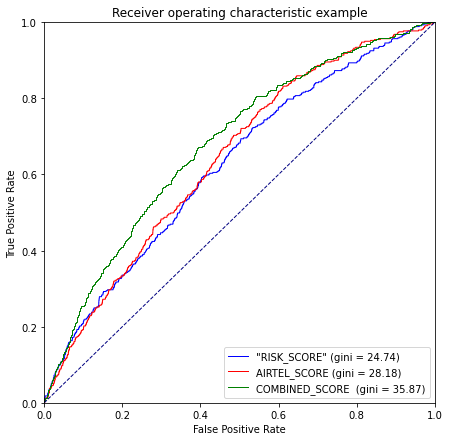

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1

fpr, tpr, thresholds = roc_curve(df_model["RISK_FSTPD30"],df_model["RISK_SCORE"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='"RISK_SCORE" (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df_model["RISK_FSTPD30"],df_model["score"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df_model["RISK_FSTPD30"],df_model["COMBINED_SCORE"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='COMBINED_SCORE  (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Exi Clients

In [22]:
df_model=  df[(df.DECISION_OVERALL.isin(['Approved']))&(df.CLIENT_EXI_3M=='Y')].dropna(subset = ["score","RISK_SCORE"])
df_model = df_model[df_model.SEGMENT=='OCT19']

df_model["score_logit"] = logit(df_model["score"])
df_model["RISK_SCORE_logit"] = logit(df_model["RISK_SCORE"])

df_model.dropna(subset = ["RISK_SCORE_logit","score_logit"], inplace = True)

from sklearn.linear_model import LogisticRegression

x_columns = ["score_logit","RISK_SCORE_logit"]
y_column = "RISK_FSTPD30"
model = LogisticRegression(penalty = 'l1')

model.fit(df_model[x_columns], df_model[y_column])

df_model["COMBINED_SCORE"] = model.predict_proba(df_model[x_columns])[:, 1]

print("Airtel Score GINI %.3f" % (2*roc_auc_score(df_model[y_column], df_model["score"])-1))
print("HC Score GINI %.3f" % (2*roc_auc_score(df_model[y_column], df_model["RISK_SCORE"])-1))
print("Combined GINI %.3f" % (2*roc_auc_score(df_model[y_column], df_model["COMBINED_SCORE"])-1))

Airtel Score GINI 0.187
HC Score GINI 0.409
Combined GINI 0.423


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


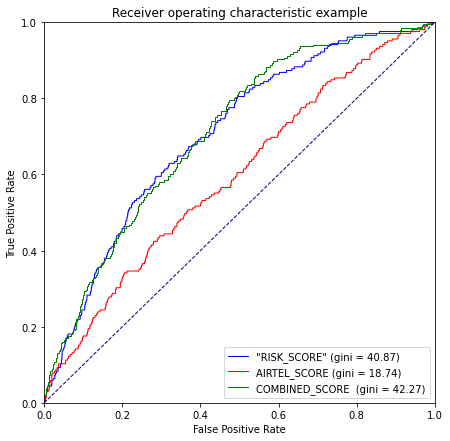

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1

fpr, tpr, thresholds = roc_curve(df_model["RISK_FSTPD30"],df_model["RISK_SCORE"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='"RISK_SCORE" (gini = %0.2f)' % ((2*roc_auc-1)*100))


fpr, tpr, thresholds = roc_curve(df_model["RISK_FSTPD30"],df_model["score"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='AIRTEL_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df_model["RISK_FSTPD30"],df_model["COMBINED_SCORE"])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='COMBINED_SCORE  (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()